This script uses NPZ files as input because Google Drive has upload limitations.

We converted:

1) The image directory -> NPZ (stores all images as compressed numpy arrays)

2) The csv file -> NPZ (stores pandas DataFrame as compressed numpy arrays)

This approach enables efficient upload while preserving the original data structure.

The following python code is appendix, showing how we convert image directory and .csv file into .npz file.

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd

def convert_csv_to_npz(csv_path, output_file, expected_rows=50000):

    df = pd.read_csv(csv_path)

    if len(df) != expected_rows:
        print(f"Warning: Found {len(df)} rows but expected {expected_rows}")

    labels_array = df.to_numpy()

    if labels_array.shape != (expected_rows, 2):
        print(f"Adjusting array shape from {labels_array.shape} to ({expected_rows}, 2)")
        labels_array = labels_array[:expected_rows, :2]


    labels_solely = labels_array[:, 1]
    print(labels_solely)

    np.savez_compressed(output_file, labels=labels_solely)
    print(f"Saved labels to {output_file} with shape {labels_solely.shape}")

    return labels_array

def convert_images_to_npz_sorted(image_dir, labels_array, output_file, target_shape=(50000, 32, 32, 3)):

    ordered_image_names = labels_array[:, 0]

    images = np.zeros(target_shape, dtype=np.uint8)

    name_to_index = {name: idx for idx, name in enumerate(ordered_image_names)}

    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]


    missing_images = set(ordered_image_names) - set(image_files)
    if missing_images:
        print(f"Warning: {len(missing_images)} images from labels not found in directory")

    processed_count = 0
    for img_file in tqdm(image_files):
        if img_file in name_to_index:
            idx = name_to_index[img_file]
            if idx >= target_shape[0]:
                continue

            img_path = os.path.join(image_dir, img_file)
            try:
                img = Image.open(img_path)
                img = img.convert('RGB')
                img_array = np.array(img)

                if img_array.shape != (32, 32, 3):
                    img = img.resize((32, 32))
                    img_array = np.array(img)

                images[idx] = img_array
                processed_count += 1
            except Exception as e:
                print(f"Error processing {img_file}: {str(e)}")
                images[idx] = np.zeros((32, 32, 3), dtype=np.uint8)

    if processed_count < len(ordered_image_names):
        print(f"Warning: Only processed {processed_count} out of {len(ordered_image_names)} expected images")

    np.savez_compressed(output_file, images=images)
    print(f"Saved {processed_count} images to {output_file} with shape {images.shape}")

    print()

train_img2label = convert_csv_to_npz("train.csv", "train_label.npz", 50000)
convert_images_to_npz_sorted(image_dir="./train_ims", labels_array=train_img2label, output_file="train_ims.npz")

test_img2label = convert_csv_to_npz("test.csv", "test_label.npz", 10000)
convert_images_to_npz_sorted(image_dir="./test_ims", labels_array=test_img2label, output_file="test_ims.npz", target_shape=(10000, 32, 32, 3))

The following is our final model.

Connect the colab to our google drive.

In [ ]:
# This mounts the Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the dataset

In [ ]:
import numpy as np

PROJECT_PATH = "MLAplus_colab"

# load data
with np.load('/content/drive/MyDrive/Colab_Notebooks/data/train_ims.npz'.format(PROJECT_PATH), allow_pickle=True) as data:
    X_train = data['images']

with np.load('/content/drive/MyDrive/Colab_Notebooks/data/train_label.npz'.format(PROJECT_PATH), allow_pickle=True) as data:
    y_train = data['labels']

with np.load('/content/drive/MyDrive/Colab_Notebooks/data/test_ims.npz'.format(PROJECT_PATH), allow_pickle=True) as data:
    X_test = data['images']

with np.load('/content/drive/MyDrive/Colab_Notebooks/data/test_label.npz'.format(PROJECT_PATH), allow_pickle=True) as data:
    y_test = data['labels']


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000,)


In [ ]:
def apply_color_jitter(image, brightness=0.2, contrast=0.2, saturation=0.2):
    # Convert to HSV for saturation adjustment
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)

    brightness_factor = 1 + np.random.uniform(-brightness, brightness)
    hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2] * brightness_factor, 0, 255)

    saturation_factor = 1 + np.random.uniform(-saturation, saturation)
    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * saturation_factor, 0, 255)

    adjusted_image = cv2.cvtColor(hsv_image.astype(np.uint8), cv2.COLOR_HSV2RGB)

    contrast_factor = 1 + np.random.uniform(-contrast, contrast)
    mean_pixel = np.mean(adjusted_image, axis=(0, 1), keepdims=True)
    adjusted_image = np.clip((adjusted_image - mean_pixel) * contrast_factor + mean_pixel, 0, 255).astype(np.uint8)

    return adjusted_image

Dataset Augmentation, with adding rotation and flipping images.

In [ ]:
import cv2

def augment_data(X, y, seed=None):
    if seed is not None:
        np.random.seed(seed)

    augmented_X = [X]
    augmented_y = [y]

    # flip
    augmented_X.append(X[:, :, ::-1, :])
    augmented_y.append(y)

    # Random rotation
    X_rotated = []
    y_rotated = []
    for img, label in zip(X, y):
        if np.random.rand() < 0.2:
            angle = np.random.uniform(-15, 15)  # Random angle between -15 and 15 degrees
            h, w = img.shape[:2]
            M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
            rotated_img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
            X_rotated.append(rotated_img)
            y_rotated.append(label)
    augmented_X.append(np.array(X_rotated))
    augmented_y.append(np.array(y_rotated))

    # # jitter
    # X_jittered = []
    # y_jittered = []
    # for img, label in zip(X, y):
    #     if np.random.rand() < 0.1:
    #         jittered_img = apply_color_jitter(img)
    #         X_jittered.append(jittered_img)
    #         y_jittered.append(label)
    # augmented_X.append(np.array(X_jittered))
    # augmented_y.append(np.array(y_jittered))

    # # crop
    # X_cropped = []
    # y_cropped = []
    # crop_margin = 16  # Total pixels to crop

    # for img, label in zip(X, y):
    #     if np.random.rand() < 0.1:
    #         h, w = img.shape[:2]
    #         crop_h, crop_w = h - crop_margin, w - crop_margin
    #         y0 = np.random.randint(0, h - crop_h + 1)
    #         x0 = np.random.randint(0, w - crop_w + 1)
    #         cropped_img = img[y0:y0 + crop_h, x0:x0 + crop_w]
    #         cropped_img = cv2.resize(cropped_img, (w, h))
    #         X_cropped.append(cropped_img)
    #         y_cropped.append(label)

    # augmented_X.append(np.array(X_cropped))
    # augmented_y.append(np.array(y_cropped))

    # combine
    X_augmented = np.concatenate(augmented_X, axis=0)
    y_augmented = np.concatenate(augmented_y, axis=0)

    return X_augmented, y_augmented

Split training set into new training set and new validation set.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

y_train = y_train.astype(int)
X_train, y_train = augment_data(X_train, y_train)

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=0
)

# X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
#     X_test_new,
#     y_test_new,
#     test_size=0.2,
#     stratify=y_test_new,
#     random_state=0
# )



print(X_train_new.shape,y_train_new.shape)
print(X_test_new.shape,y_test_new.shape)


(87947, 32, 32, 3) (87947,)
(21987, 32, 32, 3) (21987,)


1. Feature Extraction (mean RGB, color histogram, EOH, HOG, HUM, SIFT)
2. Standardization and PCA

In [ ]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import time
from skimage.feature import local_binary_pattern
from skimage.color import rgb2hsv
from skimage.feature import canny
from scipy.stats import moment



def extract_eoh_features(image, cell_size=(8, 8), bins=16):

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (0, 0), sigmaX=1.2)

    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    orientation = np.arctan2(gy, gx) * (180 / np.pi) % 180
    magnitude = np.sqrt(gx**2 + gy**2)

    high_thresh = np.percentile(magnitude[magnitude > 0], 60)
    low_thresh = 0.2 * high_thresh

    edges_thresh = cv2.Canny(
        gray, threshold1=low_thresh, threshold2=high_thresh, apertureSize=3
    )

    edges_no_thresh = (magnitude > 0).astype(np.uint8) * 255

    def compute_histogram(edge_map, ori, N=4, No=4):
        h, w = edge_map.shape
        sub_h, sub_w = h // N, w // N
        hist = np.zeros((N, N, No))

        for i in range(N):
            for j in range(N):

                y_start, y_end = i * sub_h, (i + 1) * sub_h
                x_start, x_end = j * sub_w, (j + 1) * sub_w

                sub_ori = ori[y_start:y_end, x_start:x_end]
                sub_edges = edge_map[y_start:y_end, x_start:x_end]

                bin_width = 180 / No
                quantized_ori = (sub_ori // bin_width).astype(int) % No

                for b in range(No):
                    hist[i, j, b] = np.sum((quantized_ori == b) & (sub_edges > 0))

        return hist.flatten()

    hist_thresh = compute_histogram(edges_thresh, orientation)
    hist_no_thresh = compute_histogram(edges_no_thresh, orientation)

    epoh = np.concatenate([hist_thresh, hist_no_thresh])
    epoh = epoh / (np.linalg.norm(epoh) + 1e-6)

    return epoh

def extract_hum_features(image):
    hsv = rgb2hsv(image)
    hue = hsv[:, :, 0]

    moments = []
    for i in range(1, 8):
        moments.append(moment(hue.flatten(), moment=i))

    return np.array(moments)

def extract_sift_features(image):
    sift = cv2.SIFT_create()
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, descriptors = sift.detectAndCompute(gray_image, None)
    if descriptors is None:
        descriptors = np.zeros((1,128))
    return np.mean(descriptors, axis=0)

def extract_hist_feature(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bins = 8
    hist_size = [bins, bins, bins]
    ranges = [0, 256, 0, 256, 0, 256]
    hist = cv2.calcHist([image], [0, 1, 2], None, hist_size, ranges)
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):

    hog_features_r = hog(image[:,:,0], orientations=9, pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block, transform_sqrt=True, block_norm='L2-Hys')
    hog_features_g = hog(image[:,:,1], orientations=9, pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block, transform_sqrt=True, block_norm='L2-Hys')
    hog_features_b = hog(image[:,:,2], orientations=9, pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block, transform_sqrt=True, block_norm='L2-Hys')
    hog_features = np.concatenate((hog_features_r, hog_features_g, hog_features_b))

    return hog_features

def extract_mean_rgb(image):

    mean_r = np.mean(image[:,:,0])
    mean_g = np.mean(image[:,:,1])
    mean_b = np.mean(image[:,:,2])
    mean_rgb = np.array([mean_r, mean_g, mean_b])

    return mean_rgb


def extract_combine_feature(image):

    hog_features = extract_hog_features(image)

    eoh_features = extract_eoh_features(image)

    hum_features = extract_hum_features(image)

    sift_features = extract_sift_features(image)

    hist_features = extract_hist_feature(image)

    mean_rgb = extract_mean_rgb(image)

    combined = np.concatenate((sift_features, hog_features, eoh_features, hist_features, hum_features, mean_rgb), axis=0)
    return combined

X_train_features = []
X_val_features = []
for image in X_train_new:
    combined_features = extract_combine_feature(image)
    X_train_features.append(combined_features)
for image in X_test_new:
    combined_features = extract_combine_feature(image)
    X_val_features.append(combined_features)

X_train_combined = np.array(X_train_features)
X_val_combined = np.array(X_val_features)

print(X_train_combined.shape, X_val_combined.shape)

scaler = StandardScaler()
X_train_combined_scaled = scaler.fit_transform(X_train_combined)
X_val_combined_scaled = scaler.transform(X_val_combined)

pca = PCA(n_components=500)
X_train_pca = pca.fit_transform(X_train_combined_scaled)
X_val_pca = pca.transform(X_val_combined_scaled)

# ------------------------------------------------------------
# Model Training with Combined Features
# ------------------------------------------------------------

# (A) SVM with Combined Features
# svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=0)
# train_evaluate(svm, X_train_combined_scaled, y_train_new, X_val_combined_scaled, y_test_new, "SVM (HOG+EOH+HUM)")

# # (B) Random Forest with Combined Features
# rf = RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=200, random_state=0)
# train_evaluate(rf, X_train_combined_scaled, y_train_new, X_val_combined_scaled, y_test_new, "Random Forest (HOG+EOH+HUM)")

# # (C) Logistic Regression with Combined Features
# lr = LogisticRegression(max_iter=1000, C=0.001, solver='saga', random_state=0)
# train_evaluate(lr, X_train_combined_scaled, y_train_new, X_val_combined_scaled, y_test_new, "Logistic Regression (HOG+EOH+HUM)")

# # (D) KNN with Combined Features
# knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
# train_evaluate(knn, X_train_combined_scaled, y_train_new, X_val_combined_scaled, y_test_new, "KNN (HOG+EOH+HUM)")


/usr/local/lib/python3.11/dist-packages/scipy/_lib/_util.py:798: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return fun(*args, **kwargs)


(87947, 1750) (21987, 1750)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

def train_evaluate(model, X_train, y_train, X_val, y_val, feature_name=""):

    print(f"\n{'='*50}")
    print(f"Training and Evaluating {feature_name}")
    print('='*50)

    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")

    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    start_time = time.time()
    y_val_pred = model.predict(X_val)
    predict_time = time.time() - start_time
    val_accuracy = accuracy_score(y_val, y_val_pred)

    print(f"\nTraining Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Prediction time: {predict_time:.4f} sec\n")

    print("Classification Report (Validation):")
    print(classification_report(y_val, y_val_pred))

    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {feature_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return model, train_accuracy, val_accuracy

Apply SVM


Training and Evaluating SVM)
Training completed in 10726.24 seconds

Training Accuracy: 0.9999
Validation Accuracy: 0.7699
Prediction time: 1034.5275 sec

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      2226
           1       0.86      0.88      0.87      2198
           2       0.71      0.69      0.70      2213
           3       0.61      0.62      0.62      2193
           4       0.71      0.71      0.71      2182
           5       0.68      0.66      0.67      2185
           6       0.82      0.80      0.81      2198
           7       0.82      0.79      0.80      2204
           8       0.85      0.85      0.85      2201
           9       0.86      0.85      0.85      2187

    accuracy                           0.77     21987
   macro avg       0.77      0.77      0.77     21987
weighted avg       0.77      0.77      0.77     21987



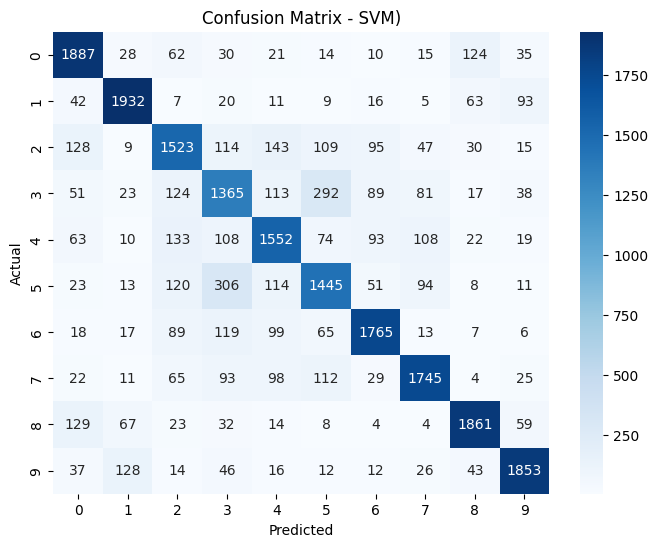

(SVC(C=10, random_state=0), 0.9998635541860439, 0.7699094919725292)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=0)
train_evaluate(svm, X_train_pca, y_train_new, X_val_pca, y_test_new, "SVM)")


Predict Test Data

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/Colab_Notebooks/data/test.csv'

df = pd.read_csv(file_path)

X_test_features = []
for image in X_test:
    combined_features = extract_combine_feature(image)
    X_test_features.append(combined_features)
X_test_combined = np.array(X_test_features)
print(f"Preprocessed test images shape: {X_test_combined.shape}")

X_test_combined_scaled = scaler.transform(X_test_combined)

X_test_pca = pca.transform(X_test_combined_scaled)
y_test_pred = svm.predict(X_test_pca)
print(f"Preprocessed test images shape: {X_test_pca.shape}")

df['label'] = y_test_pred
submission_file = '/content/drive/MyDrive/Colab_Notebooks/data/submission.csv'
df.to_csv(submission_file, index=False)

print(f"Predictions saved to {submission_file}")

Preprocessed test images shape: (10000, 1750)
Preprocessed test images shape: (10000, 500)
Predictions saved to /content/drive/MyDrive/Colab_Notebooks/data/submission.csv
